In [1]:
#imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#helpers
def load_output_format_file(_output_format_file):
    _output_dict = {}
    _fid = open(_output_format_file, 'r')
    # next(_fid)
    for _line in _fid:
        _words = _line.strip().split(',')
        _frame_ind = int(_words[0])
        if _frame_ind not in _output_dict:
            _output_dict[_frame_ind] = []
        if len(_words) == 2: #polar coordinates 
            _output_dict[_frame_ind].append([float(_words[1])])
        if len(_words) == 5: #polar coordinates 
            _output_dict[_frame_ind].append([int(_words[1]), int(_words[2]), float(_words[3]), float(_words[4])])
        elif len(_words) == 6: # cartesian coordinates
            _output_dict[_frame_ind].append([int(_words[1]), int(_words[2]), float(_words[3]), float(_words[4]), float(_words[5])])
        elif len(_words) == 7: # cartesian coordinates
            _output_dict[_frame_ind].append([int(_words[1]), int(_words[2]), float(_words[3]), float(_words[4]), float(_words[5]), float(_words[6])])    
    _fid.close()
    return _output_dict

In [15]:
#constants, variables
gt_dir = '/vast/sk8974/experiments/dsynth/data/input/gen_onlySynth_dist_noOv_3600/metadata_dev/temp/'
# pred_dir = '/vast/sk8974/experiments/dsynth/scripts/seld_run/run/results/10_1_dev_split0_accdoa_mic_gcc_20230209193217_test/'
pred_dir = '/vast/sk8974/experiments/dsynth/scripts/seld_run/run/results/21_1_dev_split0_accdoa_mic_gcc_20230310182433_test/'


In [16]:
gt_files = os.listdir(gt_dir)
pred_files = os.listdir(pred_dir)

In [17]:
def get_dist(info,coup):
    if coup:
        x, y, z = info[2], info[3], info[4]
        r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        return r  
    else:
        return info[5]

def get_df_from_dict(file):        
    df = pd.DataFrame(columns=['gt_dist','gt_class','pred_dist','dist_error','dist_abs_error'])
    gt = load_output_format_file(gt_dir + file)
    pred = load_output_format_file(pred_dir + file)
    for frame in pred:
        if frame in gt:
            gt_dist = gt[frame][0][4]
            gt_class = gt[frame][0][0]
        else:
            gt_dist = 0
            gt_class = -1

        pred_dist = pred[frame][0][0]
        dist_error = gt_dist - pred_dist
        dist_abs_error = abs(dist_error)
        df = df.append({'gt_dist': gt_dist,'gt_class':gt_class,'dist_error':dist_error,'dist_abs_error':dist_abs_error,'pred_dist':pred_dist}, ignore_index=True)
    return df


In [18]:
df_glob = pd.DataFrame(columns=['gt_dist', 'gt_class','dist_error', 'dist_abs_error', 'pred_dist'])
for file in tqdm(pred_files):
    df = get_df_from_dict(file)
    df_glob = df_glob.append(df,ignore_index=True)

100%|██████████| 900/900 [09:14<00:00,  1.62it/s]


In [19]:
df_glob_mask = df_glob.copy()
df_glob = df_glob_mask[df_glob_mask['gt_class']!=-1]
len(df_glob), len(df_glob_mask)

(350590, 540000)

In [20]:
mean_with_0 = df_glob['gt_dist'].mean()
mean_without_0 = df_glob[df_glob['gt_class']!=-1]['gt_dist'].mean()
df_glob['dist_error_with_0'] = df_glob['gt_dist'].apply(lambda x : x - mean_with_0)
df_glob['dist_abs_error_with_0'] = df_glob['gt_dist'].apply(lambda x : abs(x - mean_with_0))

df_glob['dist_error_without_0'] = df_glob['gt_dist'].apply(lambda x : x - mean_without_0)
df_glob['dist_abs_error_without_0'] = df_glob['gt_dist'].apply(lambda x : abs(x - mean_without_0))

/state/partition1/job-30901586/ipykernel_436329/839313441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glob['dist_error_with_0'] = df_glob['gt_dist'].apply(lambda x : x - mean_with_0)
/state/partition1/job-30901586/ipykernel_436329/839313441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glob['dist_abs_error_with_0'] = df_glob['gt_dist'].apply(lambda x : abs(x - mean_with_0))
/state/partition1/job-30901586/ipykernel_436329/839313441.py:6: SettingWithCopyWarning: 
A value is trying to be se

In [21]:
mean_with_0, mean_without_0

(3.6547134829858225, 3.6547134829858225)

In [22]:
cols = ['dist_abs_error_with_0','dist_abs_error', 'dist_abs_error_without_0']
for col in cols:
    print(f'{col}:{round(df_glob[col].mean(),2)}')

dist_abs_error_with_0:0.98
dist_abs_error:0.86
dist_abs_error_without_0:0.98


In [23]:
df_zero_mask = df_glob[df_glob['gt_class']!=-1].copy().reset_index()

In [24]:
df_zero_mask['dist_abs_error'].mean()

0.8592779748677738

### Plots

In [25]:
def create_scatter_plot(df):
    marker_size = 0.1
    plt.scatter(df['gt_dist'],df['dist_error'],s=marker_size)
    plt.xlabel('gt_dist')
    plt.ylabel('prediction error(gt-pr)')
    plt.title('DCASE model')
    plt.axhline(y=0, color='red', linewidth=1, linestyle='--')
    plt.show()

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

gt_dist_bins = [i for i in range(-1, 8)]
error_bins = [i for i in range(-1, 7)]

cmap = ListedColormap(plt.cm.get_cmap('RdGy')(np.linspace(0.2, 1, len(error_bins))))

err_bin_str = ['(1, 2]','(2, 3]','(3, 4]','(0, 1]','(-1, 0]','(4, 5]','(5, 6]']

def plot_error_distribution1(df1, err_col = 'dist_abs_error', title = 'CRNN model'):
    cols = ['gt_dist']
    cols.append(err_col)
    df = df1.copy()[cols]
    df['gt_dist_bin'] = pd.cut(df['gt_dist'], gt_dist_bins)
    df['error_bin'] = pd.cut(df[err_col], error_bins)
    df['error_bin'] = df['error_bin'].astype(str)
    df['gt_dist_bin'] = df['gt_dist_bin'].astype(str)
    
    df = df[['error_bin','gt_dist_bin']] 

    for i in err_bin_str:
        new_row = {'error_bin': i, 'gt_dist_bin': '(5, 6]'}
        df = df.append(new_row,ignore_index=True) 

    df_error_dist = df.groupby(['gt_dist_bin', 'error_bin']).size().unstack(fill_value=0)
    
#     import pdb; pdb.set_trace()
    df_error_dist.plot(kind='bar', stacked=True, colormap=cmap)
    plt.title(f'{title} (err dist)')
    plt.show()
    
    # add total count of bins to gt_dist_bin column to the x axis labels
    df_error_dist['total'] = df_error_dist.sum(axis=1)
    df_error_dist['total'] = df_error_dist['total'].astype(str)
    df_error_dist['gt_dist_bin'] = df_error_dist.index
    df_error_dist['gt_dist_bin'] = df_error_dist['gt_dist_bin'] + ' (N= ' + df_error_dist['total'] + ')'
    df_error_dist = df_error_dist.drop(columns=['total'])
    df_error_dist = df_error_dist.set_index('gt_dist_bin')
    
    df_error_dist_norm = df_error_dist.div(df_error_dist.sum(axis=1), axis=0)

    # plot the stacked bars with the colormap
    df_error_dist_norm.plot(kind='bar', stacked=True, colormap=cmap)
    plt.title(f'{title} (norm err dist)')
    plt.show()

    return df_error_dist


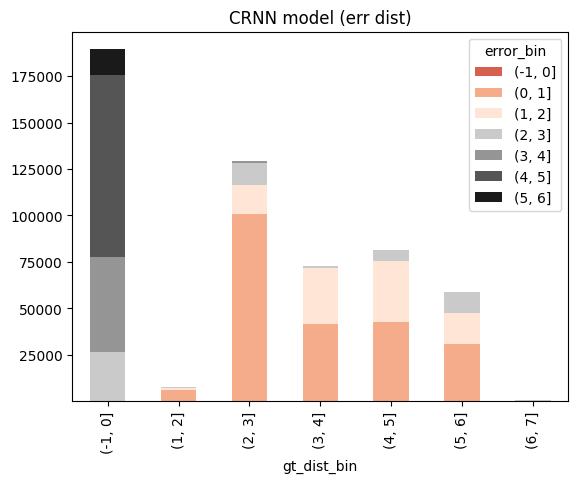

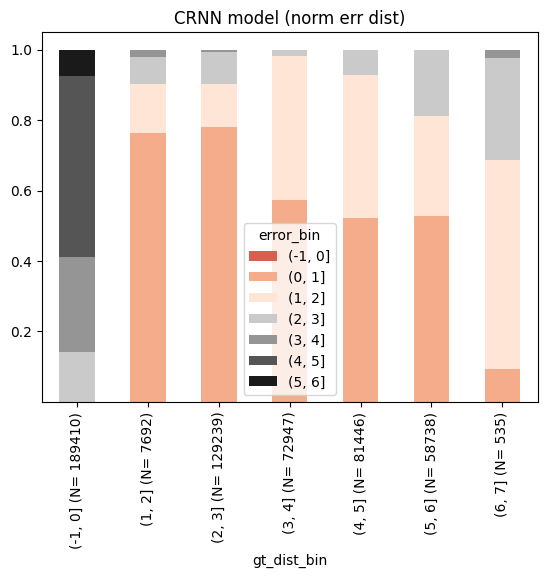

In [27]:
df_plot = plot_error_distribution1(df_glob_mask)

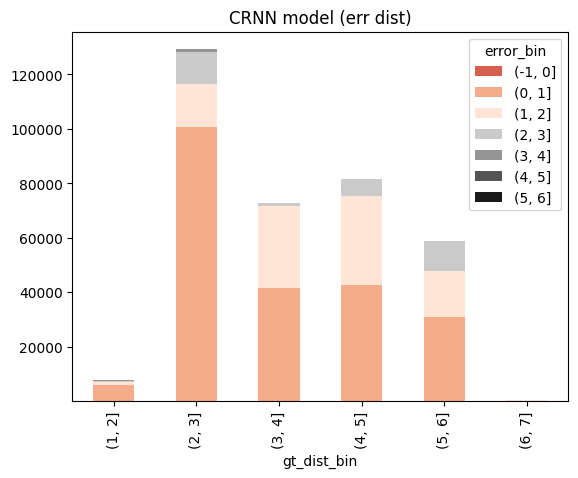

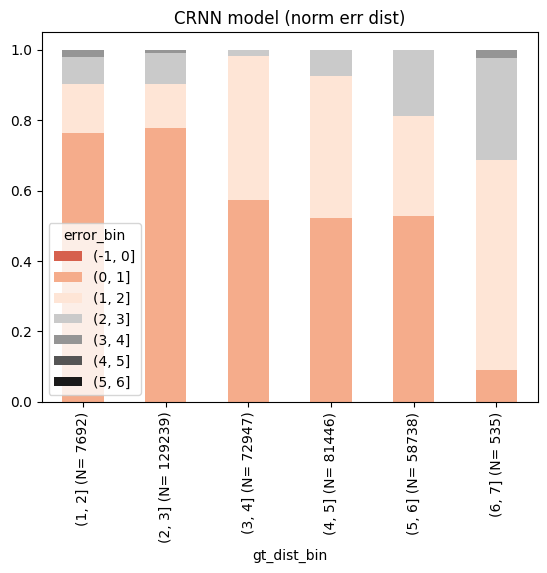

In [28]:
df_plot = plot_error_distribution1(df_glob)

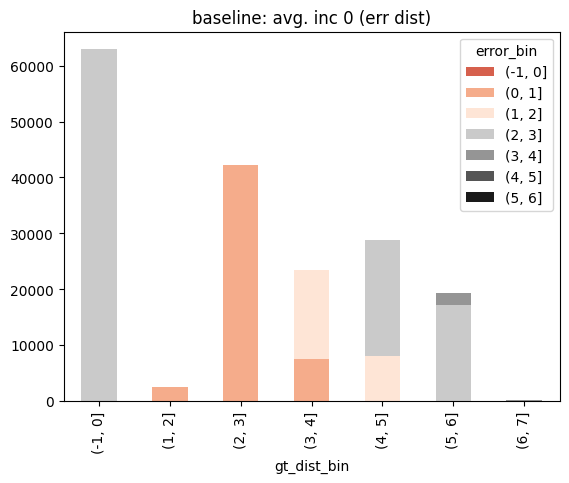

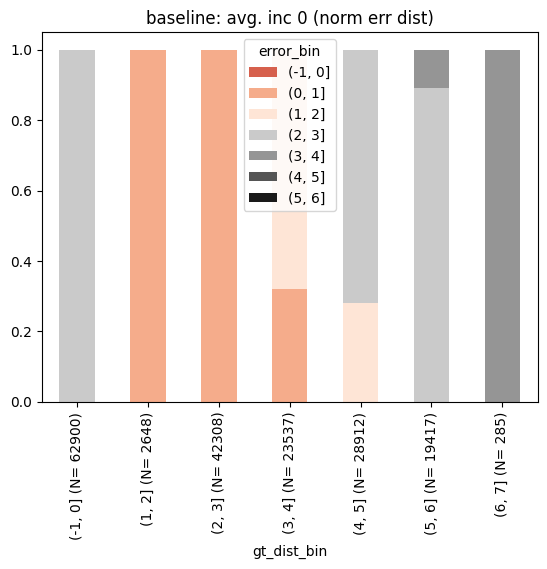

In [115]:
_ = plot_error_distribution1(df_glob, err_col='dist_abs_error_with_0', title='baseline: avg. inc 0')

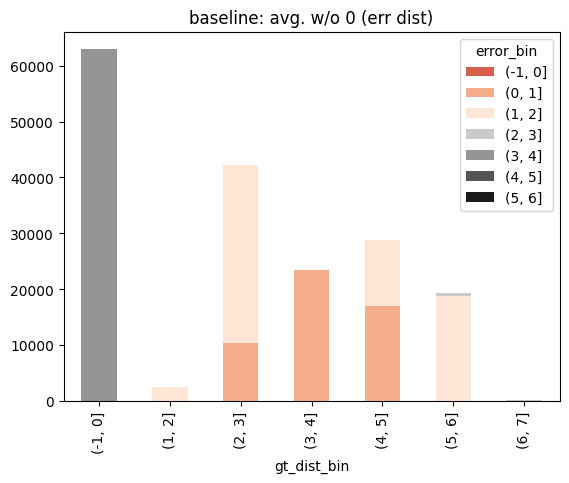

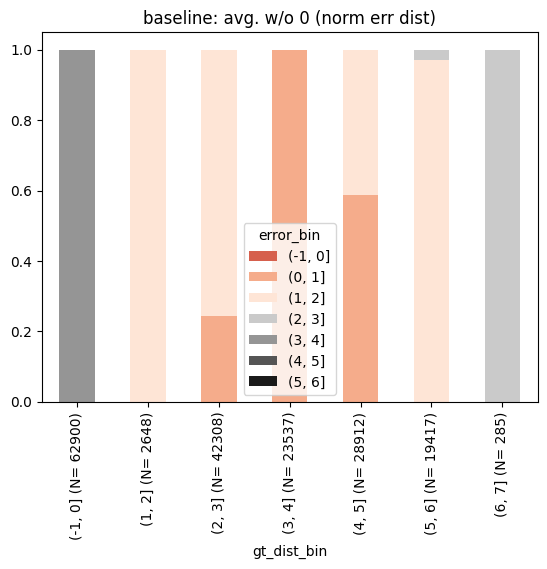

In [118]:
_ = plot_error_distribution1(df_glob, err_col='dist_abs_error_without_0', title='baseline: avg. w/o 0')


### Frame wise metrics

In [9]:
dist_thr = 1.5
df_glob['gt_present'] = df_glob['gt_class'].apply(lambda x: 0 if x<0 else 1)
df_glob['pred_present'] = df_glob['pred_dist'].apply(lambda x: 0 if x < dist_thr else 1)
df_glob.head()

,gt_dist,gt_class,distance_abs_error,pred_dist,gt_present,pred_present
0,0.0,-1.0,1.502188,1.502188,0,1
1,0.0,-1.0,1.576487,1.576487,0,1
2,0.0,-1.0,1.549721,1.549721,0,1
3,0.0,-1.0,1.537278,1.537278,0,1
4,0.0,-1.0,1.491698,1.491698,0,0


In [17]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
y_test, y_predict = df_glob['gt_present'], df_glob['pred_present']
print(f"Accuracy: {round(accuracy_score(y_test, y_predict), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_predict), 2)}")
print(f"Recall: {round(recall_score(y_test, y_predict), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_predict), 2)}")

Accuracy: 0.9
Precision: 0.91
Recall: 0.95
F1_score: 0.93


### Plots

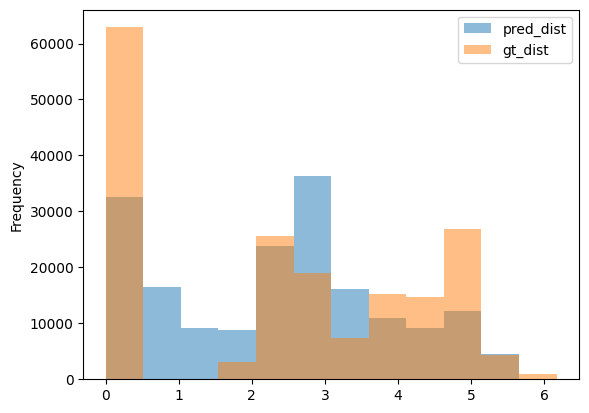

In [18]:
ax = df_glob[['pred_dist', 'gt_dist']].plot.hist(bins=12, alpha=0.5)

In [40]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,3)

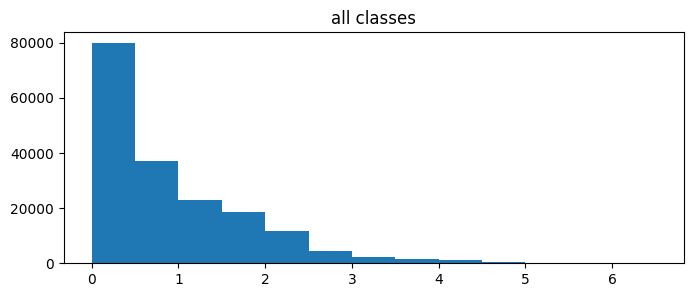

In [41]:
_ = plt.hist(df_glob['distance_abs_error'], bins=np.arange(0.0, 7, 0.5))
plt.title('all classes')
plt.show()

In [47]:
def plot_classwise_hist(curr_class):
    df = df_glob[df_glob['gt_class']==curr_class]
    _ = plt.hist(df['distance_abs_error'], bins=np.arange(0.0, 7, 0.5))
    plt.title(f'class {curr_class}')
    plt.show()

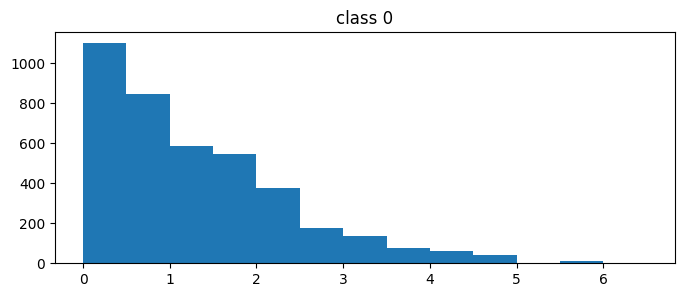

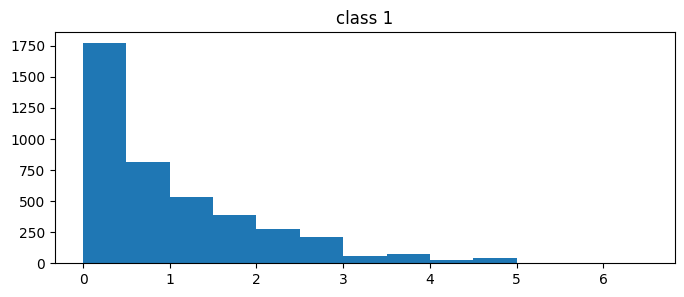

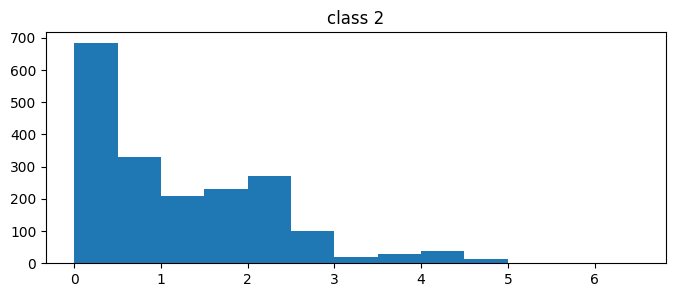

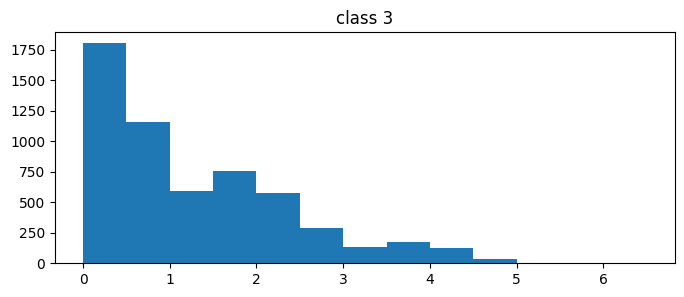

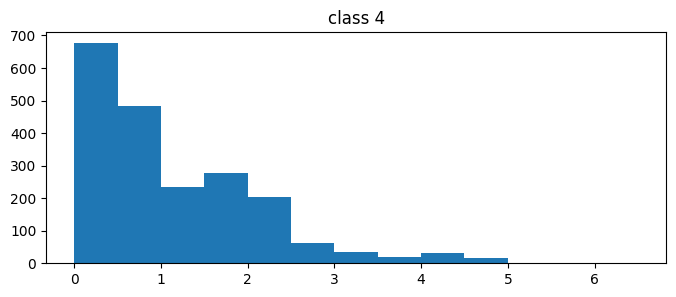

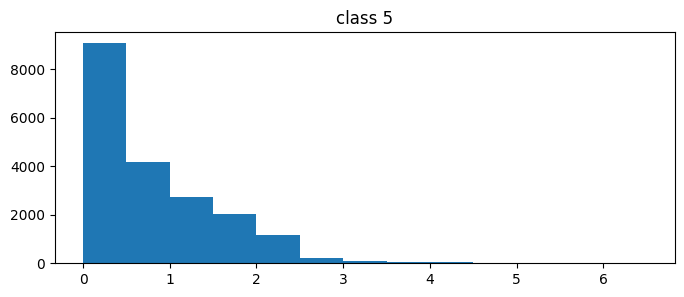

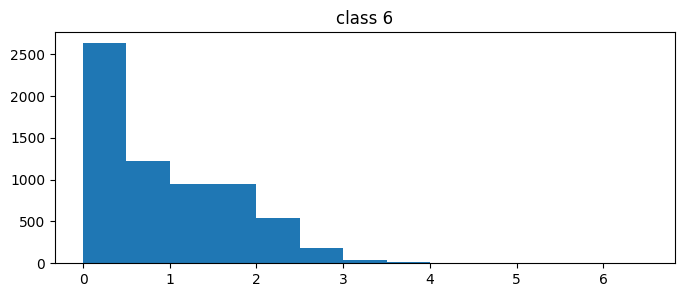

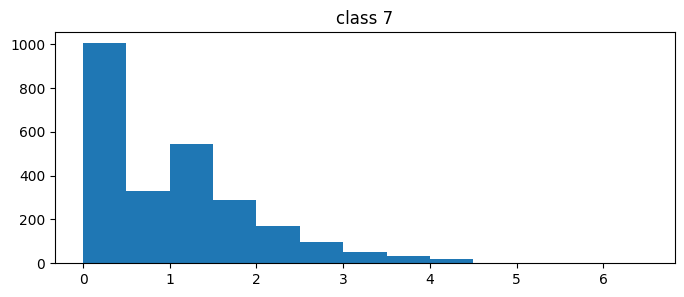

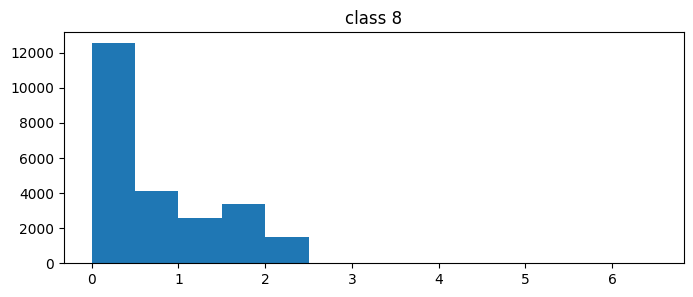

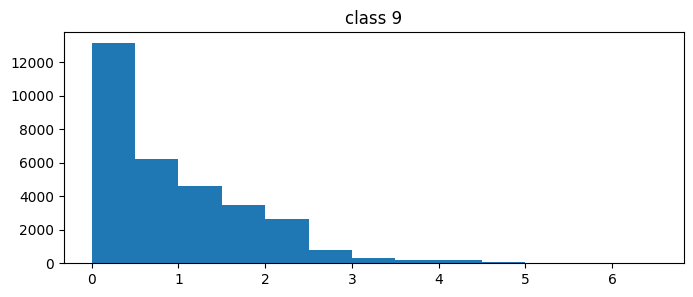

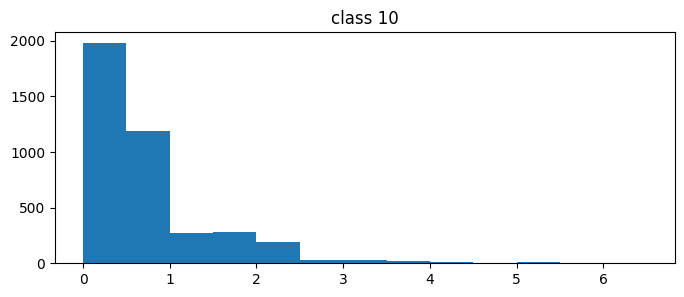

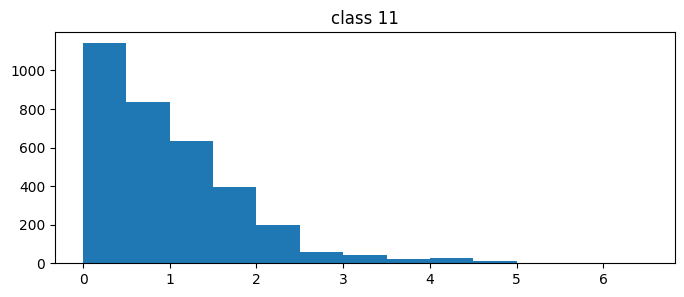

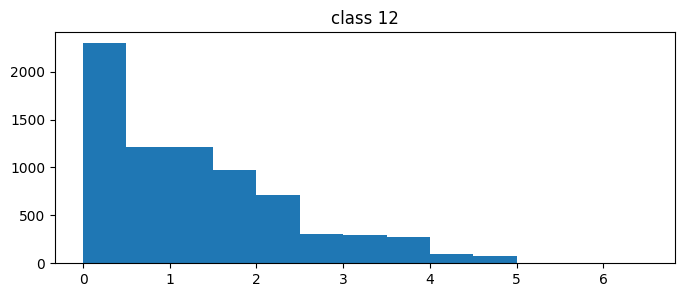

In [48]:
for i in range(13):
    plot_classwise_hist(i)

<AxesSubplot: title={'center': 'coupled'}, xlabel='gt_dist', ylabel='distance_abs_error'>

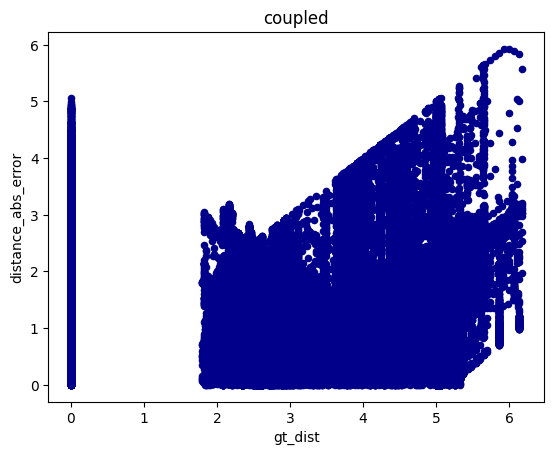

In [11]:
df_glob.plot.scatter(x='gt_dist',y='distance_abs_error',c='DarkBlue', title='coupled')

<AxesSubplot: title={'center': 'coupled'}, xlabel='gt_dist', ylabel='pred_dist'>

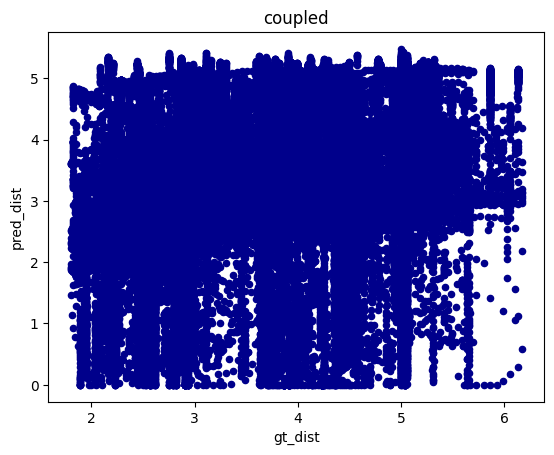

In [32]:
df_glob.plot.scatter(x='gt_dist',y='pred_dist',c='DarkBlue', title='coupled')
